# Convolutional 2D VAE

In [1]:
'''from google.colab import drive
drive.mount("/content/drive/")

%cd drive/MyDrive/Colab\ Notebooks/'''

'from google.colab import drive\ndrive.mount("/content/drive/")\n\n%cd drive/MyDrive/Colab\\ Notebooks/'

Import necessary packages

In [2]:
from glob import glob
import numpy as np
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Input,
    Flatten,
    Dense,
    Lambda,
    Reshape,
)


2023-06-06 12:53:50.604520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Input and Pre-Processing

Define core features of the dataset.

In [3]:
dim = 2
numpart = 30
latent_dim = 45
box_size = 10


Import and reshape data.

In [4]:
dump_dir = "/Users/lorenzobarbiero/Documents/GitHub/variational-autoencoders/mc-sampling/good-runs/"
# read all position files in chosen directory
files = glob(dump_dir + "gamma*_x.txt")
# sort files by gamma value
files = np.array(files)[np.argsort([f.split("_")[1] for f in files])]

# if different from zero, you can pick a single file with a specific gamma
choose_one_gamma = 0

if choose_one_gamma != 0:
    gamma = choose_one_gamma
    num_gammas = 1

    fname = [f for f in files if f.split("_")[1] == str(gamma)][0]
    data = np.loadtxt(fname)
    vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
    labels = np.zeros(len(data))
else:
    num_gammas = files.size
    arrays = [np.loadtxt(f) for f in files]

    # combine data + reshape, and assign labels to different datasets
    data = np.vstack(arrays)
    vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
    labels = np.hstack([[i] * len(a) for i, a in enumerate(arrays)])

print("Original array shape:", data.shape)
print("Reshaped array shape:", vcs.shape)


Original array shape: (40000, 60)
Reshaped array shape: (40000, 30, 2)


Sort by distance from origin

In [5]:
sort_idx = np.argsort(vcs[:, :, 0] ** 2 + vcs[:, :, 1] ** 2)
sorted_vcs = np.array(
    [sample[sort_idx[i]] for i, sample in enumerate(vcs)]
)


### Compute distance matrices

In [6]:
# metric="euclidean", force="no", checks=True are by default
dm = np.array([squareform(pdist(sample)) for sample in sorted_vcs])

print("Distance matrix shape:", dm.shape)

Distance matrix shape: (40000, 30, 30)


Split in training and test set

In [7]:
train_perc = 0.8

m = sorted_vcs.shape[0]  # total number of samples
m_training = int(m * train_perc)  # samples in the training set
m_test = m - m_training  # samples in the test set

while True:
    permutation = np.random.permutation(m)

    sorted_vcs = sorted_vcs[permutation]
    labels = labels[permutation]
    dm = dm[permutation]

    trainset_conf = sorted_vcs[:m_training]
    testset_conf = sorted_vcs[m_training:]

    trainset_mat = dm[:m_training]
    testset_mat = dm[m_training:]

    counts = [
        np.count_nonzero(labels[:m_training] == i)
        for i in range(num_gammas)
    ]

    # if each label is represented by at least half of
    # training set size / number of files
    # we're good and we can stop permutating
    if all(c > int(m_training / (2 * num_gammas)) for c in counts):
        break

print("Shape of the training set: ", trainset_conf.shape)
print("Shape of the test set: ", testset_mat.shape)


Shape of the training set:  (32000, 30, 2)
Shape of the test set:  (8000, 30, 30)


## Variational Auto Encoder (Model 1)

### Sampling class

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### Encoder

In [9]:
encoder_inputs = keras.Input(shape=(numpart, numpart, 1))
x = Conv2D(32, 3, padding="same", activation="relu")(encoder_inputs)
# x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
conv_shape = K.int_shape(x)  # Shape of conv to be provided to decoder
x = Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(
    encoder_inputs, [z_mean, z_log_var, z], name="encoder"
)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 30, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 57600)        0           ['conv2d_1[0][0]']               
                                                                                            

2023-06-06 12:53:55.236752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Decoder

In [10]:
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
x = Dense(
    conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu"
)(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(64, 3, padding="same", activation="relu")(x)
# x = Conv2DTranspose(128, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding="same", activation="relu")(x)
decoder_outputs = Conv2DTranspose(
    1, 3, padding="same", activation="sigmoid", name="decoder_output"
)(x)

decoder = keras.Model(decoder_input, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 45)]              0         
                                                                 
 dense (Dense)               (None, 57600)             2649600   
                                                                 
 reshape (Reshape)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 30, 30, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 30, 30, 1)        289 

### VAE Class

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            size = reconstruction.shape[
                1:
            ]  # Extract dimensions excluding the first 'None' dimension
            #noise = np.random.normal(0, 0.1, size=size)
            #reconstruction = reconstruction + noise

            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [25]:
reg_lambda = 0.001
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)  # lower learning rate
fit = vae.fit(trainset_mat, epochs=10, batch_size=128, verbose=2)

Epoch 1/10
250/250 - 139s - loss: 0.0031 - reconstruction_loss: 0.0017 - kl_loss: 1.3467 - 139s/epoch - 556ms/step
Epoch 2/10
250/250 - 144s - loss: 0.0028 - reconstruction_loss: 0.0014 - kl_loss: 1.3503 - 144s/epoch - 576ms/step
Epoch 3/10
250/250 - 146s - loss: 0.0027 - reconstruction_loss: 0.0014 - kl_loss: 1.3486 - 146s/epoch - 582ms/step
Epoch 4/10
250/250 - 149s - loss: 0.0027 - reconstruction_loss: 0.0013 - kl_loss: 1.3459 - 149s/epoch - 594ms/step
Epoch 5/10
250/250 - 156s - loss: 0.0026 - reconstruction_loss: 0.0013 - kl_loss: 1.3478 - 156s/epoch - 622ms/step
Epoch 6/10
250/250 - 173s - loss: 0.0026 - reconstruction_loss: 0.0013 - kl_loss: 1.3429 - 173s/epoch - 693ms/step
Epoch 7/10
250/250 - 166s - loss: 0.0026 - reconstruction_loss: 0.0012 - kl_loss: 1.3406 - 166s/epoch - 664ms/step
Epoch 8/10
250/250 - 162s - loss: 0.0025 - reconstruction_loss: 0.0012 - kl_loss: 1.3382 - 162s/epoch - 646ms/step
Epoch 9/10
250/250 - 165s - loss: 0.0025 - reconstruction_loss: 0.0012 - kl_loss

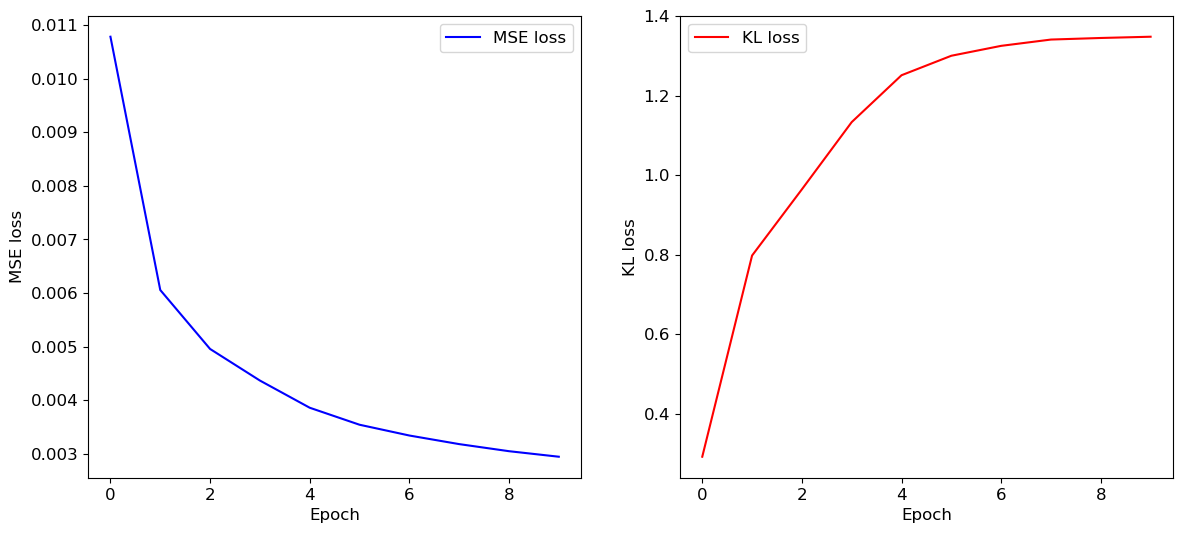

In [13]:
plt.rcParams["font.size"] = 12
fig, AX = plt.subplots(1, 2, figsize=(14, 6.0))
ax = AX[0]
ax.plot(fit.history["loss"], label="MSE loss", c="b")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax.legend()
ax = AX[1]
ax.plot(fit.history["kl_loss"], label="KL loss", c="r")
ax.set_xlabel("Epoch")
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [26]:
encoded_test = np.array(vae.encoder.predict(testset_mat))
encoded_train = np.array(vae.encoder.predict(trainset_mat))

print(encoded_test.shape)


1000/1000 [==============================] - 21s 21ms/step
(3, 8000, 45)


We can now use the data to decode

In [27]:
decoded_test = np.array(decoder.predict(encoded_test[2, :, :])).reshape(
    -1, numpart, numpart
)
decoded_train = np.array(decoder.predict(encoded_train[2, :, :])).reshape(
    -1, numpart, numpart
)
print(decoded_test.shape)

1000/1000 [==============================] - 47s 47ms/step
(8000, 30, 30)


### Check reconstruction

<Axes: >

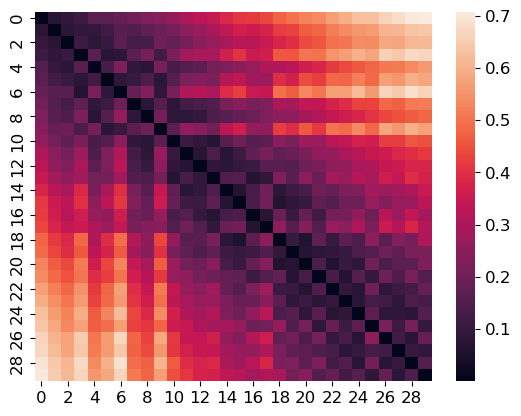

In [28]:
ind = 20
df = pd.DataFrame(decoded_test[ind])
sns.heatmap(data=df)

<Axes: >

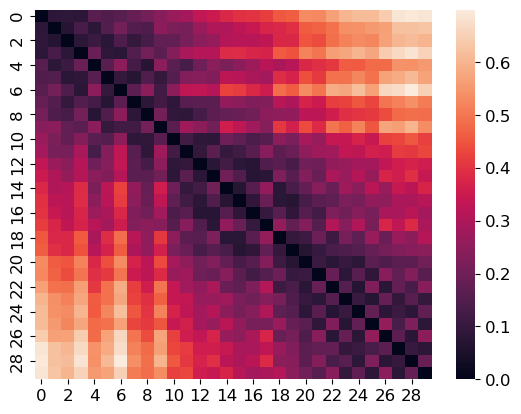

In [29]:
df2 = pd.DataFrame(testset_mat[ind])
sns.heatmap(data=df2)

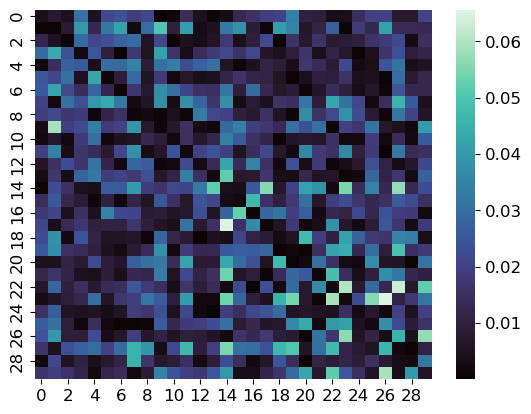

In [30]:
df3 = pd.DataFrame(abs(testset_mat[ind]-decoded_test[ind]))
sns.heatmap(data=df3, cmap="mako");

## Coordinates Reconstructor (Model 2)
The reconstructor is trained on the original distance matrices and predicts the decoded matrices

In [47]:
rec_inputs = keras.Input(shape=(numpart, numpart, 1))
x = Conv2D(64, 3, padding='same', activation='relu')(rec_inputs)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = Conv2D(1, 3, padding='same', activation='relu')(x)
x = Flatten()(x) #Flatten
x = layers.Dense(int(numpart**2 *2/5), activation='relu')(x)
x = layers.Dense(int(numpart**2 *1/5), activation='relu')(x)
x = layers.Dense(int(numpart*dim))(x)
rec_outputs = Reshape((numpart, dim))(x)
reconstruction = keras.Model(rec_inputs,rec_outputs)
reconstruction.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        18464     
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 1)         289       
                                                                 
 flatten_1 (Flatten)         (None, 900)               0         
                                                                 
 dense_1 (Dense)             (None, 360)               324360    
                                                                 
 dense_2 (Dense)             (None, 180)               64980 

In [48]:
reconstruction.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.MeanSquaredError(),
)  # lower learning rate
fit = reconstruction.fit(
    trainset_mat, trainset_conf, epochs=50, batch_size=128, verbose=2
)

Epoch 1/50
250/250 - 39s - loss: 0.0189 - 39s/epoch - 158ms/step
Epoch 2/50
250/250 - 46s - loss: 0.0115 - 46s/epoch - 183ms/step
Epoch 3/50
250/250 - 48s - loss: 0.0107 - 48s/epoch - 191ms/step
Epoch 4/50
250/250 - 48s - loss: 0.0098 - 48s/epoch - 191ms/step
Epoch 5/50
250/250 - 49s - loss: 0.0090 - 49s/epoch - 196ms/step
Epoch 6/50
250/250 - 49s - loss: 0.0083 - 49s/epoch - 198ms/step
Epoch 7/50
250/250 - 50s - loss: 0.0079 - 50s/epoch - 200ms/step
Epoch 8/50
250/250 - 54s - loss: 0.0075 - 54s/epoch - 214ms/step
Epoch 9/50
250/250 - 58s - loss: 0.0072 - 58s/epoch - 230ms/step
Epoch 10/50
250/250 - 58s - loss: 0.0070 - 58s/epoch - 234ms/step
Epoch 11/50
250/250 - 61s - loss: 0.0067 - 61s/epoch - 246ms/step
Epoch 12/50
250/250 - 59s - loss: 0.0065 - 59s/epoch - 238ms/step
Epoch 13/50
250/250 - 56s - loss: 0.0063 - 56s/epoch - 224ms/step
Epoch 14/50
250/250 - 53s - loss: 0.0062 - 53s/epoch - 214ms/step
Epoch 15/50
250/250 - 53s - loss: 0.0061 - 53s/epoch - 211ms/step
Epoch 16/50
250/250

KeyboardInterrupt: 

In [ ]:
rec_test = np.array(reconstruction.predict(testset_mat))
rec_test_dec = np.array(reconstruction.predict(decoded_test))

### Evaluate performance
Original data is in blue, reconstructed original configurations in gold

In [ ]:
ind = 20
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_test[ind, :, 0] * l, rec_test[ind, :, 1] * l, s=30, c="gold"
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
ax.set_xlim(-0.15, 1.15)
ax.set_ylim(-0.15, 1.15)

Original data is in 

In [ ]:
ind = 20
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_test_dec[ind, :, 0] * l,
    rec_test_dec[ind, :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
ax.set_xlim(-0.15, 1.15)
ax.set_ylim(-0.15, 1.15)

In [ ]:
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots()

nframes = 100


# Define the animation function
def update(ind):
    ax.clear()
    plt.scatter(
        rec_test[ind, :, 0] * l, rec_test[ind, :, 1] * l, s=20, c="b"
    )
    plt.scatter(
        testset_conf[ind, :, 0] * l,
        testset_conf[ind, :, 1] * l,
        s=20,
        c="y",
    )
    ax.set_title(f"Scatter plot ({ind}/{nframes})")
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)


# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=400)

# Save the animation as a GIF
animation.save("conv2dist.gif", writer="imagemagick")

## Alternative coordinates reconstructor
Another way to achieve coordinates from the distance matrix is through a more analytical method that does not involve Machine Learning

Step 1: retrieve coordinates from distance matrix (shifted and rotated)

In [31]:
def gram_to_coordinates(distance_matrix):
    # Get the number of points
    n = distance_matrix.shape[0]

    # Compute the Gram matrix
    gram_matrix = -0.5 * (distance_matrix ** 2)

    # Center the Gram matrix
    gram_matrix_centered = gram_matrix - np.mean(gram_matrix, axis=0) - np.mean(gram_matrix, axis=1)[:, np.newaxis] + np.mean(gram_matrix)

    # Perform eigendecomposition of the centered Gram matrix
    eigenvalues, eigenvectors = np.linalg.eigh(gram_matrix_centered)

    # Sort eigenvalues and eigenvectors in descending order
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]

    # Extract the positive square root of eigenvalues
    sqrt_eigenvalues = np.sqrt(np.maximum(eigenvalues, 0))

    # Compute the coordinates of the points in 2D space
    coordinates = eigenvectors[:, :2] * sqrt_eigenvalues[:2]

    return coordinates

In [32]:
coordinates = gram_to_coordinates(decoded_train[1])
print("Coordinates of points:")
print(coordinates)

Coordinates of points:
[[-0.24158767 -0.21117675]
 [-0.17860486 -0.21232878]
 [-0.18289018 -0.16516355]
 [-0.31937867 -0.08399197]
 [-0.09343315 -0.17154637]
 [-0.13076815 -0.09944503]
 [-0.238334   -0.02484495]
 [-0.02741428 -0.12851976]
 [-0.06957219 -0.04979628]
 [-0.2791914   0.03561107]
 [ 0.03327189 -0.16145197]
 [-0.24002816  0.08206722]
 [-0.1025923   0.04054413]
 [ 0.07604786 -0.08439998]
 [ 0.05313582 -0.00964423]
 [-0.04211014  0.09760311]
 [ 0.14319596 -0.08732308]
 [ 0.11505885  0.01559325]
 [ 0.21200275 -0.09346654]
 [ 0.22777265 -0.06667715]
 [ 0.15878643  0.06074374]
 [ 0.05429789  0.1931448 ]
 [-0.24691252  0.30712926]
 [ 0.24325451  0.03710966]
 [ 0.30260584 -0.06169733]
 [ 0.2874736   0.02891483]
 [-0.36625051  0.38618875]
 [ 0.35403636 -0.02267604]
 [ 0.23523997  0.19977501]
 [ 0.27468112  0.2458065 ]]


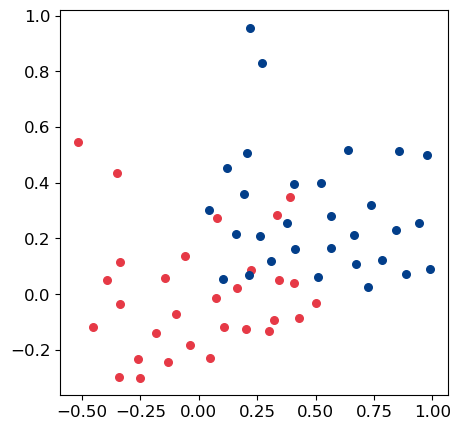

In [33]:
ind = 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    coordinates[ :, 0] * l,
    coordinates[ :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    trainset_conf[ind, :, 0] * l,
    trainset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
#ax.set_xlim(-0.15, 1.15)
#ax.set_ylim(-0.15, 1.15)

Step 2: find the optimal angle and traslation vector for each configuration

In [34]:
def align_points(points1, points2):
    # Center the points by subtracting their means
    centered_points1 = points1 - np.mean(points1, axis=0)
    centered_points2 = points2 - np.mean(points2, axis=0)

    # Compute the covariance matrix
    covariance_matrix = centered_points2.T @ centered_points1

    # Perform singular value decomposition (SVD)
    U, _, Vt = np.linalg.svd(covariance_matrix)

    # Calculate the optimal rotation matrix
    rotation_matrix = Vt.T @ U.T

    # Calculate the optimal translation vector
    translation_vector = np.mean(points2, axis=0) - np.mean(points1 @ rotation_matrix, axis=0)
    
    # Transform points1 using the estimated rotation and translation
    transformed_points = points1 @ rotation_matrix + translation_vector

    return transformed_points

def find_best_params(points):
    centered_points = points - np.mean(points, axis=0)
    
    def sign(x):
        if x>0:
            return 1
        if x<0:
            return -1
        return 0
    # order by distance form the center
    centered_points = np.array(sorted(centered_points, key=lambda x: x[0]**2 + x[1]**2, reversed=True))
    # take 3 furthest
    selected_points = [centered_points[i] for i in range(3)]
    
    # going in decreasing distance order, check if each successive point is
    ##  within the poligon with the currently selected point as vertices
    for p in centered_points:
        # to find if it's within the polygon, check the halfplane given by the two closest
        p1,p2 = [pi+p for pi in sorted(selected_points-p, key=lambda x: x[0]**2 + x[1]**2)[:2]]
        norm = np.array([p1[1]-p2[1], p2[0]-p1[0]])
        centr = (p1+p2)/2
        
        if not sign(np.dot(p-centr,norm)) == sign(np.dot(-centr, norm)):
            # if not in poligon, select the point
            selected_points.append(p)
            
    # find the polygon segment that is closer to the center
    selected_points = sorted(selected_points, key=lambda x: np.arctan2(x[1], x[0]))
    dists = [0 for i in range(len(selected_points))]
    for i in range(len(selected_points)):
        p1 = selected_points[i]
        p2 = selected_points[i-1]
        
        norm = np.array([p1[1]-p2[1], p2[0]-p1[0]])
        norm /= (norm[0]**2+norm[1]**2)**0.5
        centr = (p1+p2)/2
        dists[i] = np.dot(-centr, norm)
    
    c_ind = dists.index(min(dists)) # index of closest segment
    
    # turn points so that segment faces down
    p1 = selected_points[i]
    p2 = selected_points[i-1]
    norm = np.array([p1[1]-p2[1], p2[0]-p1[0]])
    
    theta = np.arctan2(norm[1], norm[0])
    rot_mat = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
    
    centered_points = centered_points@rot_mat
    # shift in place
    centered_points += centered_points.min(axis=0)
    return centered_points

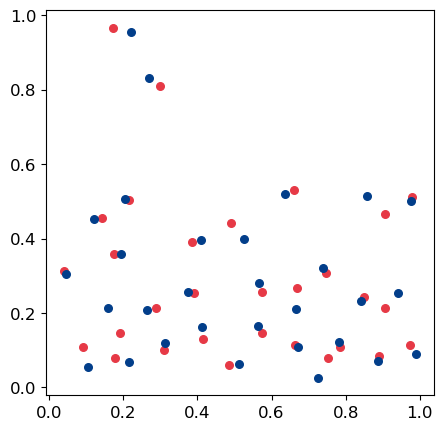

In [35]:
coordinates = align_points (coordinates, trainset_conf[1])
ind = 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    coordinates[ :, 0] * l,
    coordinates[ :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    trainset_conf[ind, :, 0] * l,
    trainset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)

In [38]:
dm = np.array([squareform(pdist(sample)) for sample in sorted_vcs])

rec_test_dec = np.zeros((testset_conf.shape))

for i in range(0,len(rec_test_dec)):
    rec_test_dec[i] = align_points(gram_to_coordinates(decoded_test[i]),testset_conf[i])


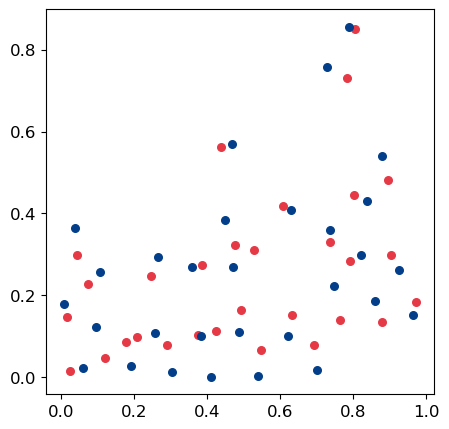

In [42]:
ind = 70
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_test_dec[ind, :, 0] * l,
    rec_test_dec[ind, :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)

## Deez Labels

In [43]:
import sklearn
from sklearn.decomposition import PCA


def label_vis(vae, data, labels):
    # prediction
    z_mean, _, _ = vae.encoder.predict(data)

    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(z_mean)
    variance_ratio = pca.explained_variance_ratio_
    print(variance_ratio)

    # plot
    plt.figure(figsize=(5, 5))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

1250/1250 [==============================] - 18s 14ms/step
[0.03936338 0.03657885]


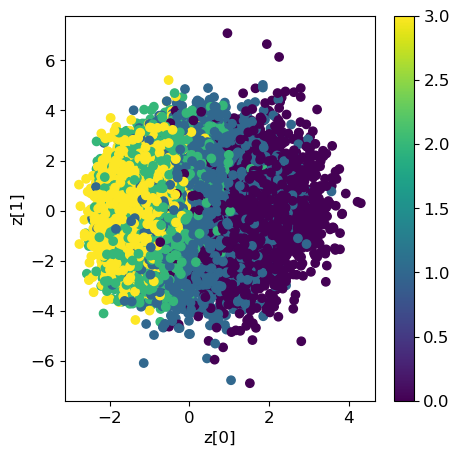

In [44]:
label_vis(vae, dm, labels)


## Energy test

In [45]:
def potential(x):
    """
    Calculate LJ + gravitational potential given a positions array.

    INPUTS
        x: array of shape (num_particles, dimension)

    NOTE: gamma is a global variable
    """

    n = len(x)
    pot = 0.0
    for i in range(n - 1):
        pot += gamma * x[i, -1]
        for j in range(i + 1, n):
            r2 = np.sum((x[i, :] - x[j, :]) ** 2)
            if r2 < 9.0:  # r_cut = 3 sigma
                sr6 = 1.0 / r2**3
                pot += 4 * (sr6**2 - sr6)
    pot += gamma * x[-1, -1]

    return pot


In [46]:
scale_factor = box_size * np.sqrt(dim)
ori_pots = [potential(sample) for sample in testset_conf * scale_factor]
rec_pots = [potential(sample) for sample in rec_test * scale_factor]

NameError: name 'gamma' is not defined

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].hist(ori_pots, bins=30, facecolor="gold")
ax[0].set_title("Original")
ax[1].hist(rec_pots, bins=30, facecolor="blue")
ax[1].set_title("Reconstruction")

for i in range(2):
    ax[i].set_xlabel("Potential")
    ax[i].set_ylabel("Counts per bin")
    ax[i].grid(axis="y", alpha=0.1, color="black")